# JaCoCo Visualization

In [33]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

jacoco_path = '../../generated/code-analysis/jacoco.csv'

if not os.path.exists(jacoco_path):
    raise FileNotFoundError(f"Le fichier JaCoCo n'existe pas : {jacoco_path}. Exécutez le notebook 'notebooks/arrange data/JaCoCo.ipynb' pour le générer.")

out_jacoco_path = '../../generated/figures/jacoco'
if not os.path.exists(out_jacoco_path):
    os.makedirs(out_jacoco_path)

df_jacoco = pd.read_csv(jacoco_path)
cols = ['instruction', 'branch', 'line', 'method']

# Effet d'ordre

In [76]:
from notebooks.analysis import tests

results = []
alpha = 0.05

for metric in cols:
    pivot = df_jacoco.pivot(index='user', columns='game_mode', values=metric)
    pivot = pivot.dropna()

    groups = df_jacoco.drop_duplicates('user')[['user', 'group']]
    pivot = pivot.merge(groups.set_index('user'), left_index=True, right_index=True)

    pivot['diff'] = pivot['leaderboard'] - pivot['achievements']

    group_a = pivot[pivot['group'] == 'A']['diff']
    group_b = pivot[pivot['group'] == 'B']['diff']

    assert len(group_a) == len(group_b), f"Mismatch in sample size for {metric}"

    # Test de normalité
    _, p_normal_diff_a = stats.shapiro(group_a)
    _, p_normal_diff_b = stats.shapiro(group_b)

    # Test variance
    stat, variance_p_value = stats.levene(group_a, group_b)

    # Choix du test
    if p_normal_diff_a > 0.05 and p_normal_diff_b > 0.05:
        t_stat, p_value = stats.ttest_ind(leaderboard, achievements, equal_var=True)
        test = "t-test"
    else:
        t_stat, p_value = stats.mannwhitneyu(leaderboard, achievements)
        test = "Wilcoxon"

    a12 = tests.vargha_delaney_a12(leaderboard, achievements)

    results.append([
        metric.capitalize(),
        p_normal_diff_a > 0.05,
        p_normal_diff_b > 0.05,
        variance_p_value > 0.05,
        test,
        p_value,
        p_value < alpha,
        a12,
        tests.a12_label(a12)
    ])

order_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

order_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney
0,Instruction,True,True,True,t-test,0.910668,False,0.449219,Aucun effet
1,Branch,False,True,True,Wilcoxon,0.637129,False,0.449219,Aucun effet
2,Line,True,True,True,t-test,0.910668,False,0.449219,Aucun effet
3,Method,True,True,True,t-test,0.910668,False,0.449219,Aucun effet


In [75]:
order_effect_df_count = len(order_effect_df[order_effect_df['significant'] == True])
if significant_count_a > 0:
    print(f"Il y a {significant_count_a} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucune effet d'ordre.


# Effet de session

In [84]:
from notebooks.analysis import tests

results = []
alpha = 0.05

for metric in cols:
    df_rounds = df_jacoco.copy()
    df_rounds['round'] = df_rounds.groupby('user').cumcount() + 1

    # Comparer les performances au round 1 vs round 2
    session1 = df_rounds[df_rounds['session'] == 1][metric]
    session2 = df_rounds[df_rounds['session'] == 2][metric]

    assert len(session1) == len(session2), f"Mismatch in sample size for {metric}"

    # Normalité ?
    _, p_shapiro_1 = stats.shapiro(session1)
    _, p_shapiro_2 = stats.shapiro(session2)

    # Test variance
    stat, variance_p_value = stats.levene(session1, session2)

    if p_shapiro_1 > 0.05 and p_shapiro_2 > 0.05:
        t_stat, p_value = stats.ttest_rel(session1, session2)  # si apparié
        test = "t-test"
    else:
        t_stat, p_value = stats.wilcoxon(session1, session2)
        test = "Wilcoxon"


    a12 = tests.vargha_delaney_a12(session1, session2)

    results.append([
        metric.capitalize(),
        p_shapiro_1 > 0.05,
        p_shapiro_2 > 0.05,
        variance_p_value > 0.05,
        test,
        p_value,
        p_value < alpha,
        a12,
        tests.a12_label(a12)
    ])

session_effect_df = pd.DataFrame(results, columns=[
    'metric',
    'a_normal',
    'b_normal',
    'variance_equals',
    'test',
    'p_value',
    'significant',
    'vargha_delaney_a12',
    'vargha_delaney'
])

session_effect_df

,metric,a_normal,b_normal,variance_equals,test,p_value,significant,vargha_delaney_a12,vargha_delaney
0,Instruction,False,True,True,Wilcoxon,0.743561,False,0.470703,Aucun effet
1,Branch,False,True,True,Wilcoxon,0.119357,False,0.382812,Effet moyen
2,Line,False,True,True,Wilcoxon,0.668549,False,0.507812,Aucun effet
3,Method,False,True,True,Wilcoxon,0.795820,False,0.505859,Aucun effet


In [85]:
session_effect_df_count = len(session_effect_df[session_effect_df['significant'] == True])
if significant_count_a > 0:
    print(f"Il y a {session_effect_df_count} un effet d'ordre.")
else:
    print("Aucun effet d'ordre.")

Aucun effet d'ordre.


# Graphiques

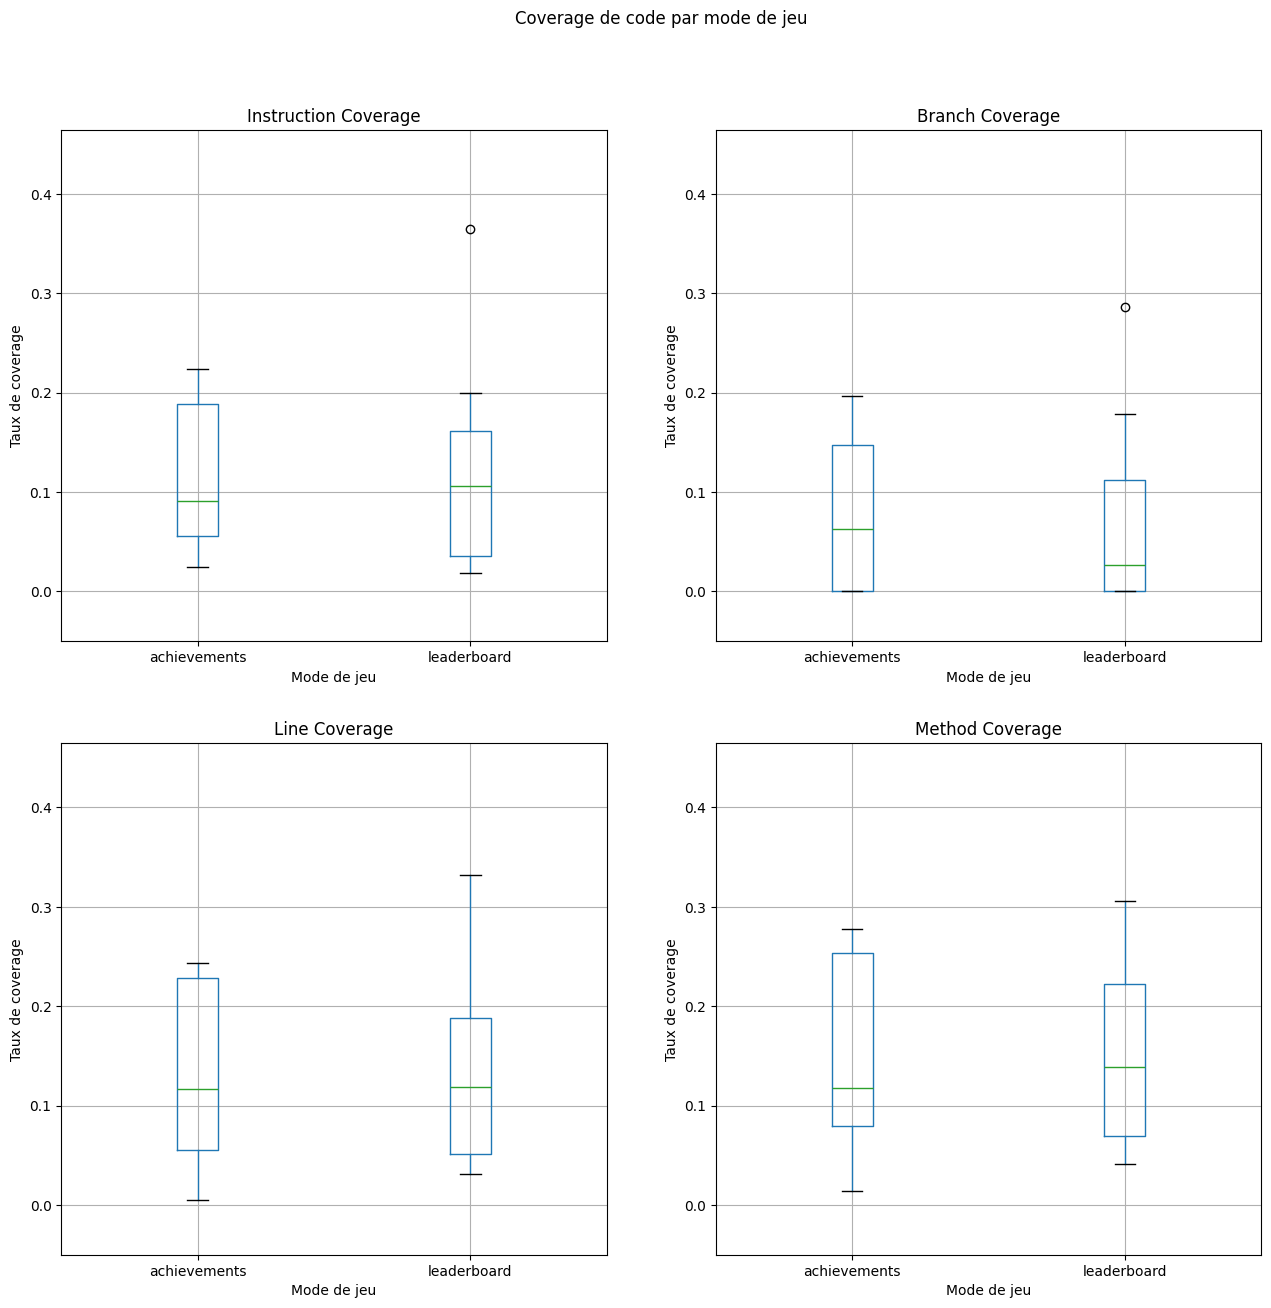

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.ravel()

y_max = df_jacoco[cols].max().max() + 0.1

for i, metric in enumerate(cols):
    ax = axs[i]
    bp = df_jacoco.boxplot(column=metric, by='game_mode', ax=ax)
    ax.set_title(f'{metric.capitalize()} Coverage')
    ax.set_ylabel('Taux de coverage')
    ax.set_xlabel('Mode de jeu')
    ax.grid(True)
    ax.set_ylim(-0.05, y_max)

plt.suptitle('Coverage de code par mode de jeu')
plt.savefig(f"{out_jacoco_path}/coverage_by_game_mode.png")
plt.show()

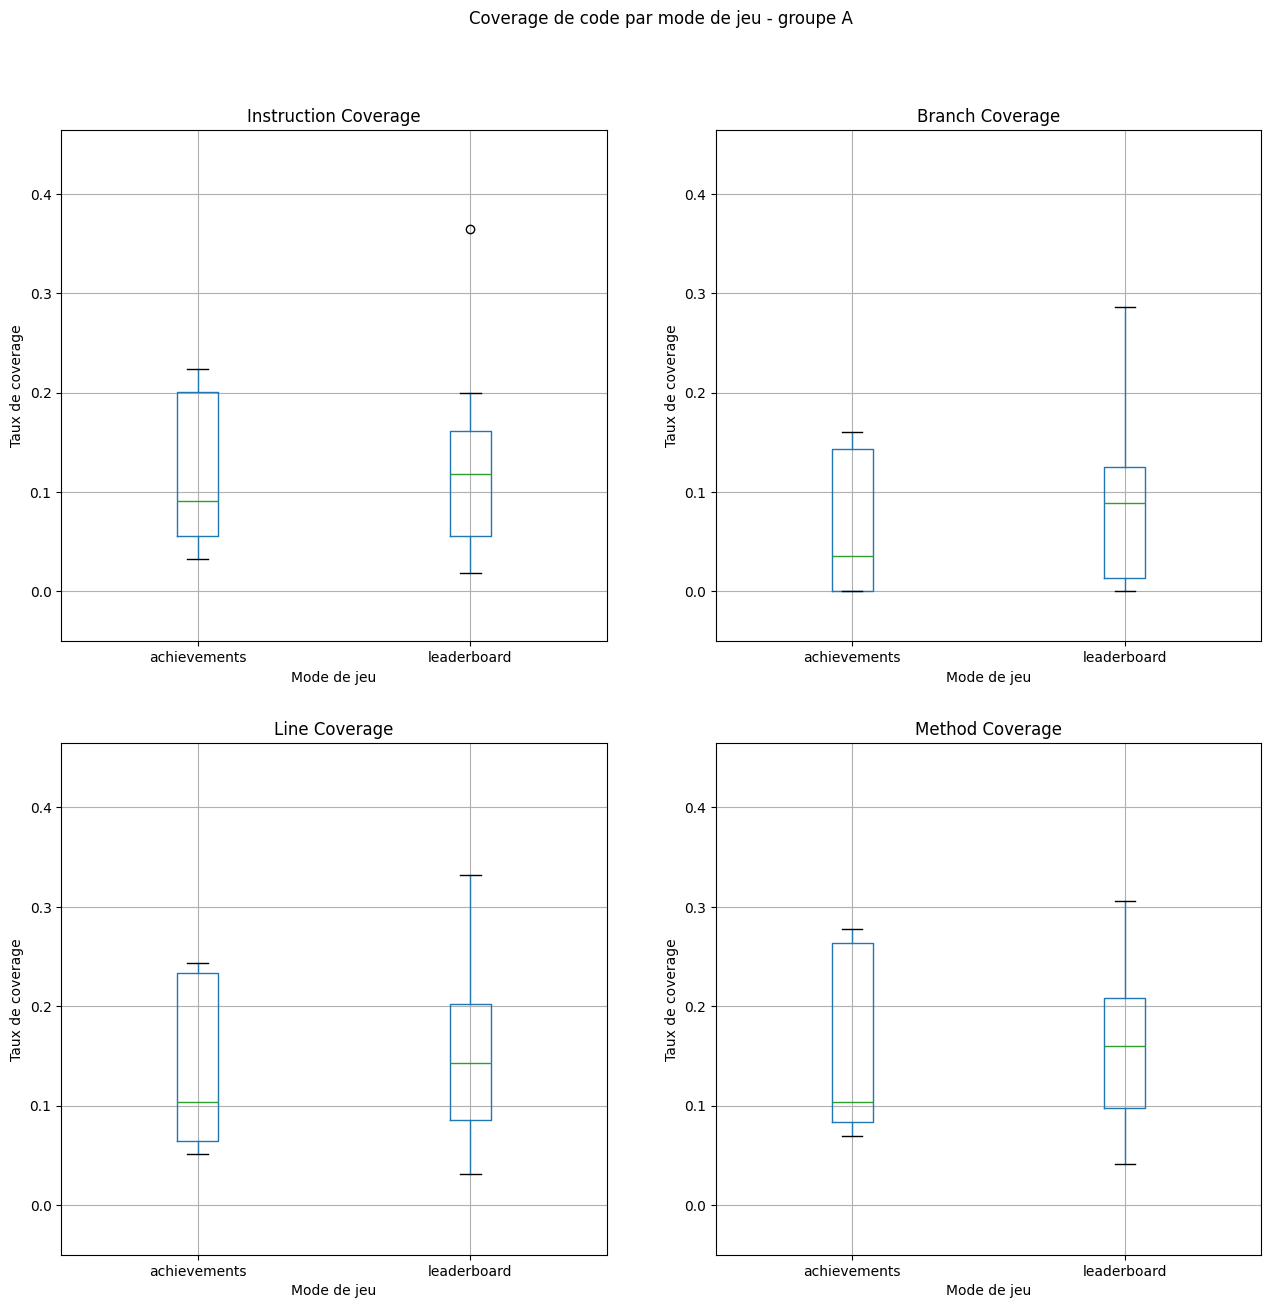

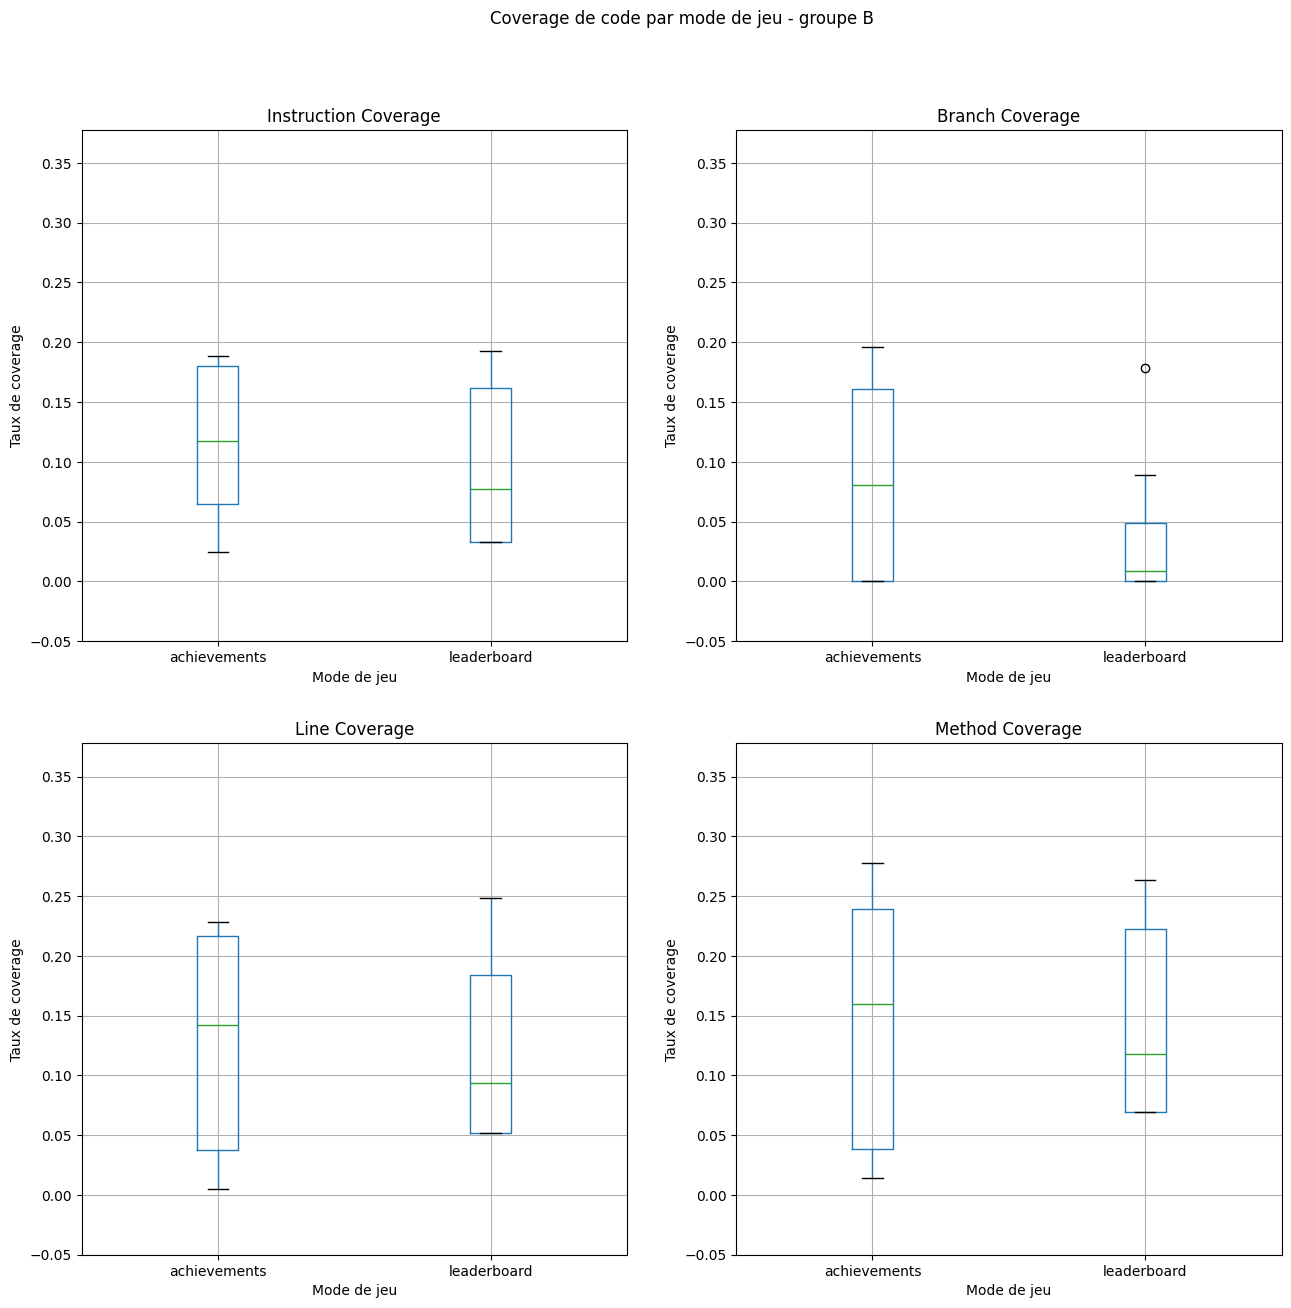

In [49]:
for group in ['A', 'B']:
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.ravel()

    data = df_jacoco[df_jacoco['group'] == group]

    y_max = data[cols].max().max() + 0.1

    for i, metric in enumerate(cols):
        ax = axs[i]
        bp = data.boxplot(column=metric, by='game_mode', ax=ax)
        ax.set_title(f'{metric.capitalize()} Coverage')
        ax.set_ylabel('Taux de coverage')
        ax.set_xlabel('Mode de jeu')
        ax.grid(True)
        ax.set_ylim(-0.05, y_max)

    plt.suptitle(f'Coverage de code par mode de jeu - groupe {group}')
    plt.savefig(f"{out_jacoco_path}/coverage_by_game_mode_group_{group}.png")
    plt.show()